# 다중선형회귀 (1) - 농어의 무게 예측 모형 만들기

독립변수가 두 개 이상인 경우의 선형회귀분석

분석 정확도를 높이기 위해 적절하지 않은 변수를 추려내는 과정을 반복적으로 수행하여 최적의 독립변수 그룹을 찾아내는 것을 목표로 한다.

이번 예제에서는 변수를 추려내는 과정을 수행하지 않고 다중선형회귀를 수행한다.

## #01. 준비작업

### [1] 패키지 참조

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import numpy as np
import seaborn as sb
from tabulate import tabulate        # 데이터프레임을 텍스트처럼 출력해주는 라이브러리
from matplotlib import pyplot as plt
from pandas import read_excel, DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from scipy.stats import t
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

비표준화 계수 B => 원데이터의 coef

표준화 계수 $ \beta $ => StandardScaler의 coef

### [2] 그래프 초기화

In [7]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["axes.unicode_minus"] = False

### [3] 데이터 가져오기

In [8]:
origin = read_excel("https://data.hossam.kr/mldata/fish.xlsx")
print(origin.info()) # 데이터타입 확인 및 결측치 확인용
origin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB
None


,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


## #02. 데이터 확인

### [1] 산점도 행렬

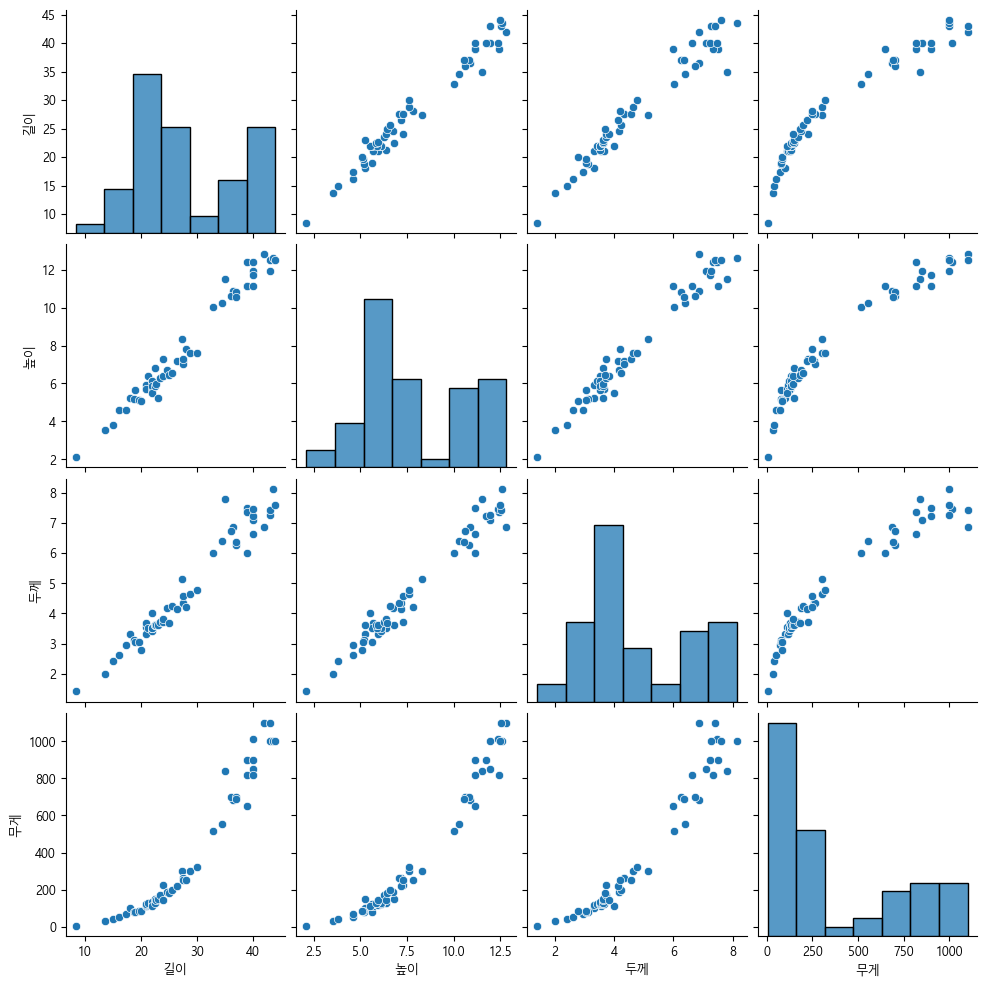

In [9]:
sb.pairplot(origin)
plt.show()
plt.close()

> 종속변수인 무게에 길이, 높이, 두께가 모두 높은 상관성을 갖는 것으로 보인다. 무게에 대해 선형보다는 비선형으로 보이지만 여기서는 선형성을 만족한다고 가정하고 진행한다.
>
> 독립변수간(길이-높이, 높이-두께, 두께-길이)에도 상관성이 있는 것으로 확인된다. 이와 같은 경우를 자기상관이 있다고 하는데, 이 경우 회귀분석을 수행하면 다중공선성 문제가 발생하여 모델의 신뢰성이 떨어진다. 
> 
> 예제 데이터이므로 여기서는 다중공선성을 무시하고 진행하도록 한다.

### [2] 상관계수 히트맵

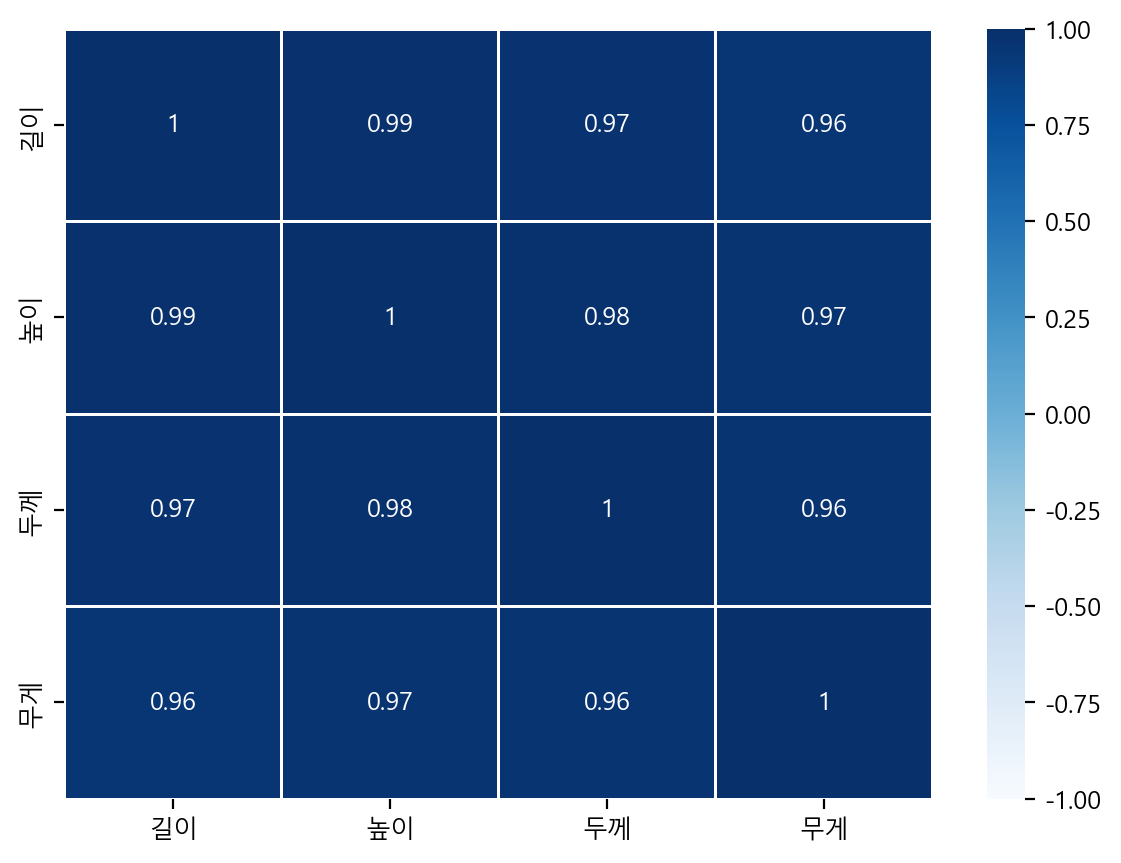

In [10]:
plt.figure(figsize=(7,5), dpi=200)
sb.heatmap(origin.corr(method='pearson'), annot = True, cmap = 'Blues',
           vmin = -1, vmax=1, linewidths=0.5)
plt.show()
plt.close()

> 요인들간의 자기상관성이 있는 것으로 보인다.

## #03. 데이터 전처리

데이터를 분리한다.

In [11]:
x = origin[['길이', '높이', '두께']]
y = origin['무게']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 3), (17, 3), (39,), (17,))

## #04. 선형회귀 분석

+--------------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|              |   결정계수(R2) |   평균절대오차(MAE) |   평균제곱오차(MSE) |   평균오차(RMSE) |   평균 절대 백분오차 비율(MAPE) |   평균 비율 오차(MPE) |
|--------------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------|
| 선형회귀분석 |       0.919246 |             58.2871 |             8828.88 |          93.9621 |                          327.91 |               304.702 |
+--------------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+



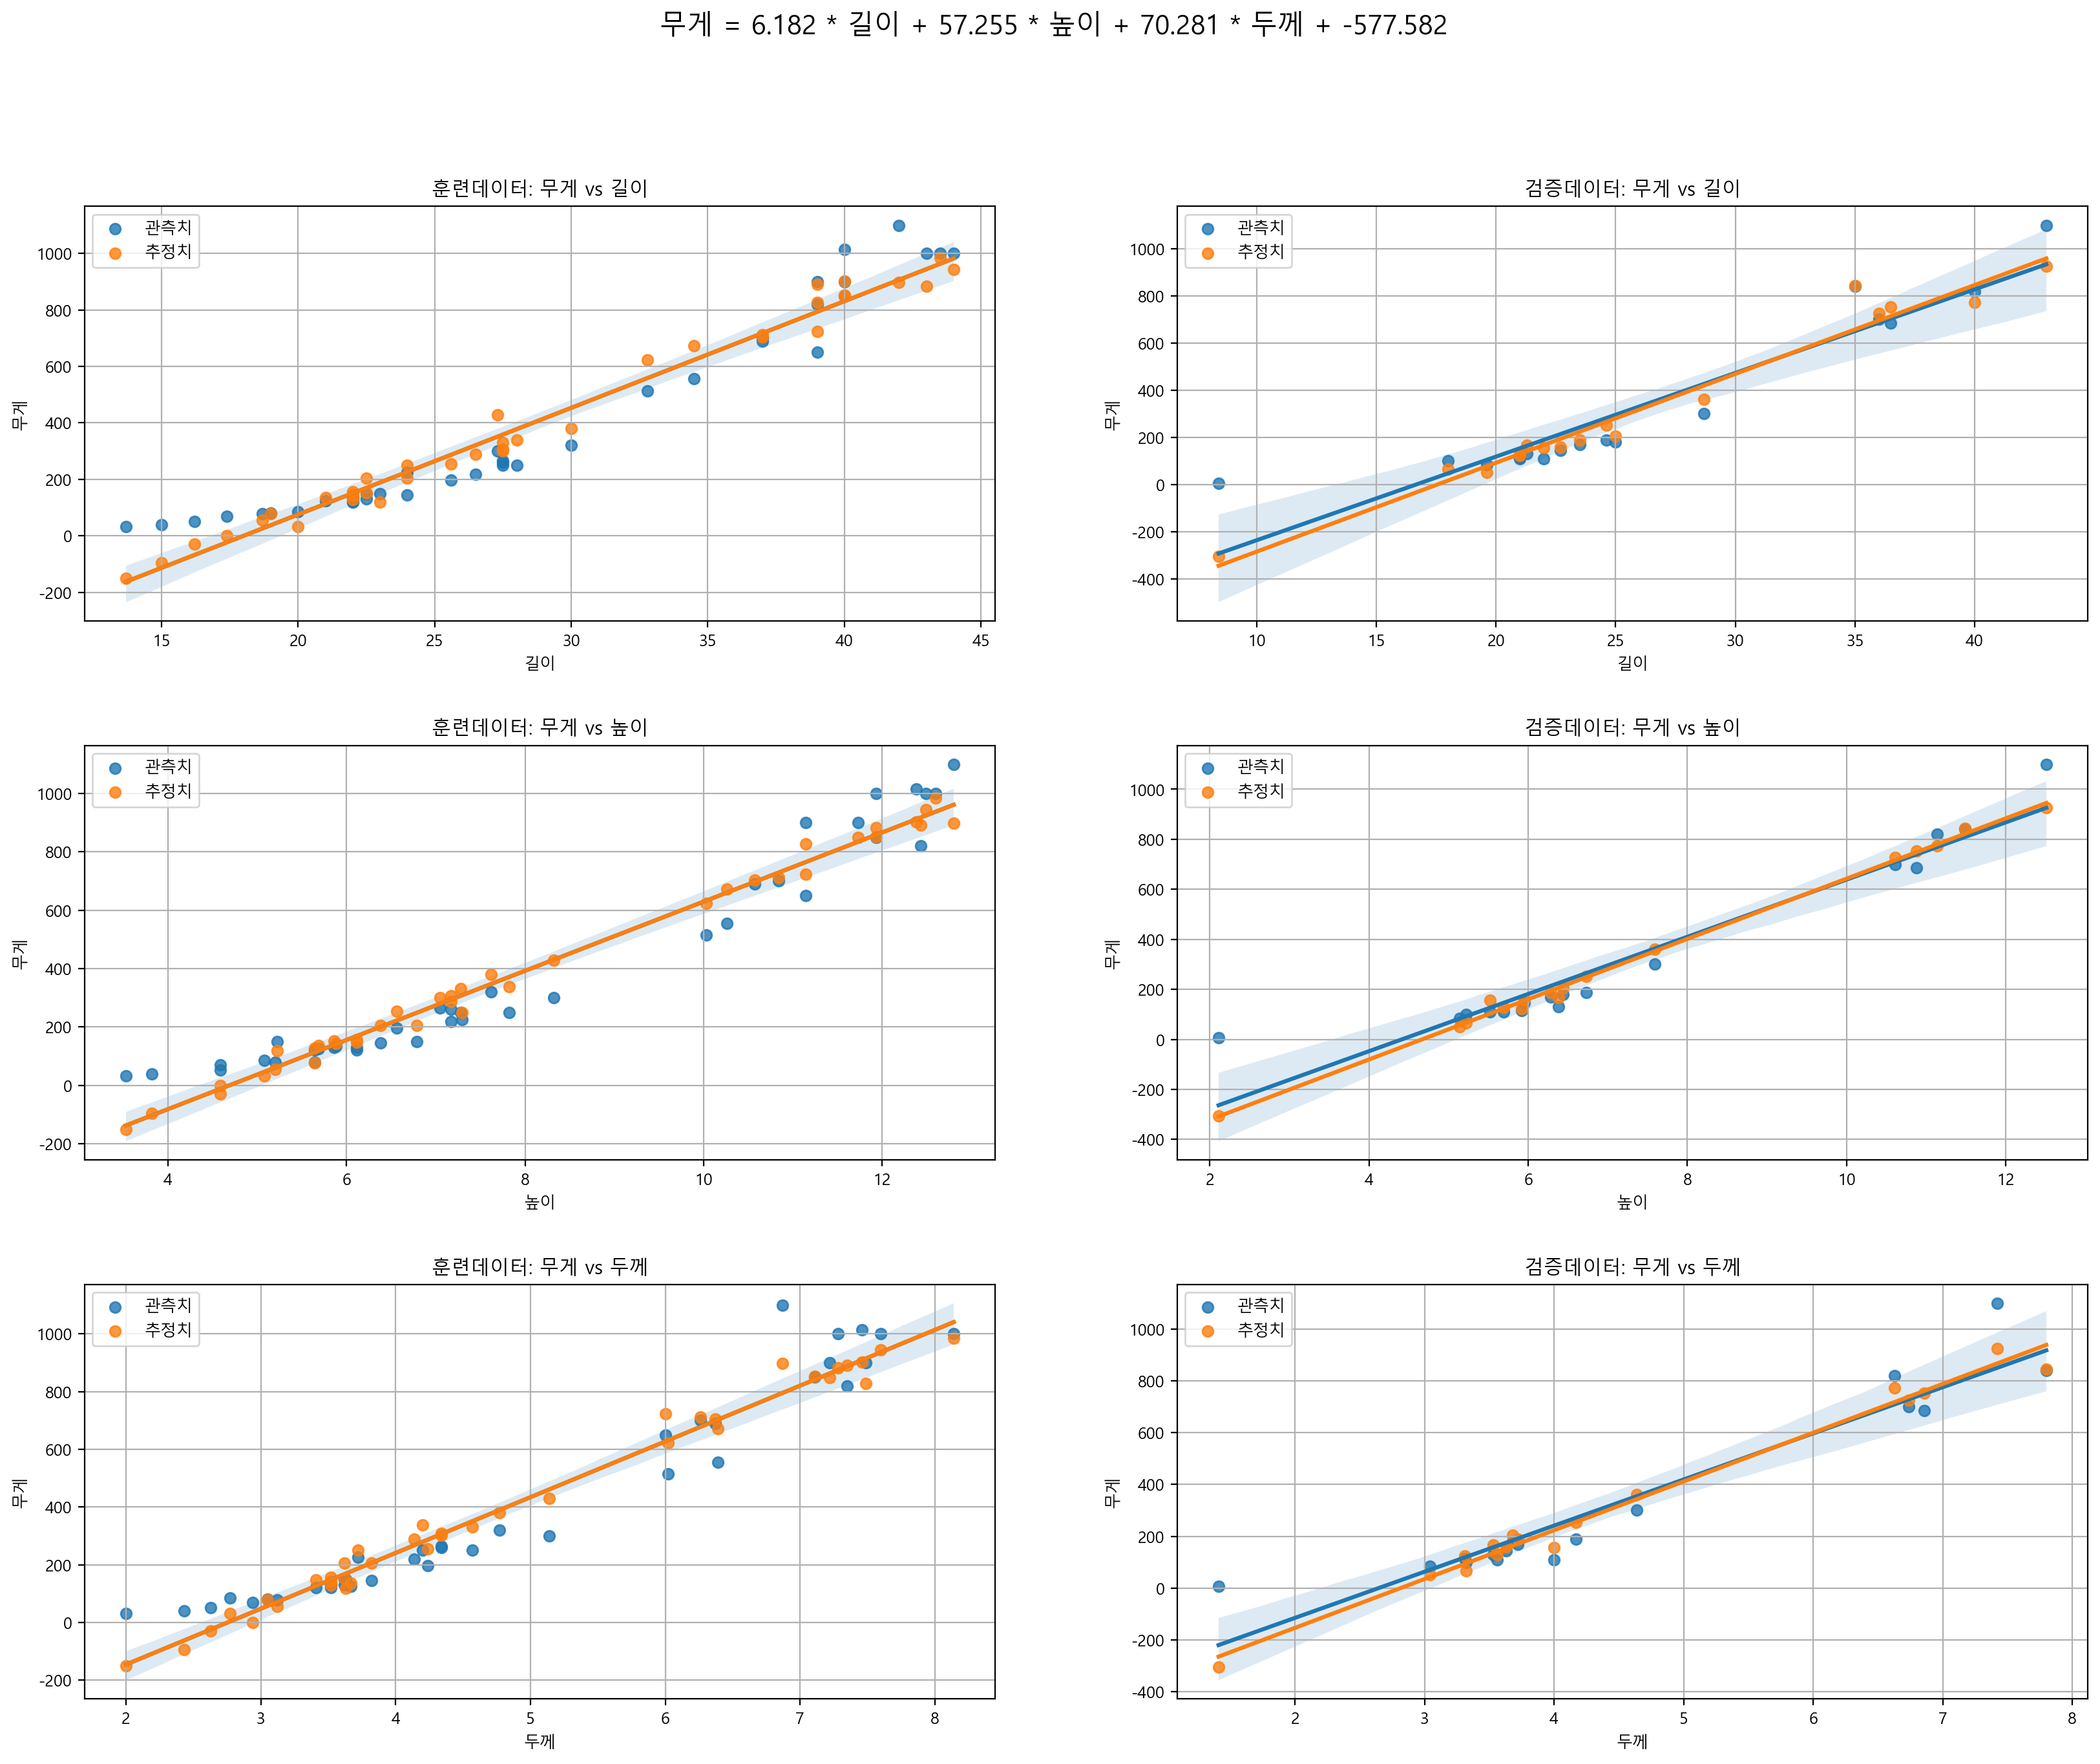

In [17]:
yname = '무게'
xnames = x_train.columns
size = len(xnames)

# 분석모델 생성
model = LinearRegression()
fit = model.fit(x_train, y_train)

# 회귀식
expr = f"{yname} = "
for i, v in enumerate(xnames):
    expr += f"{fit.coef_[i]:0.3f} * {v} + " 
    
expr += f"{fit.intercept_:0.3f}" 

# 추정치 생성
y_train_pred = fit.predict(x_train)
y_test_pred = fit.predict(x_test)

# 성능평가
result = {
    "결정계수(R2)": r2_score(y_test, y_test_pred),
    "평균절대오차(MAE)": mean_absolute_error(y_test, y_test_pred),
    "평균제곱오차(MSE)": mean_squared_error(y_test, y_test_pred),
    "평균오차(RMSE)": np.sqrt(mean_squared_error(y_test, y_test_pred)),
    "평균 절대 백분오차 비율(MAPE)": np.mean(np.abs((y_test - y_test_pred) / y_test) * 100),
    "평균 비율 오차(MPE)": np.mean((y_test - y_test_pred) / y_test * 100)
}

result_df = DataFrame(result, index=["선형회귀분석"])
print(tabulate(result_df, headers='keys', tablefmt='psql', showindex=True), end="\n\n")

# 시각화
fig, ax = plt.subplots(size, 2, figsize=(20, 5*size), dpi=200)
fig.subplots_adjust(hspace=0.3)
fig.suptitle(expr, fontsize=15)

for i, v in enumerate(xnames):
    sb.regplot(x=x_train[v], y=y_train, ci=95, ax=ax[i][0], label='관측치')
    sb.regplot(x=x_train[v], y=y_train_pred, ci=0, ax=ax[i][0], label='추정치')
    ax[i][0].set_title(f"훈련데이터: 무게 vs {v}")
    ax[i][0].legend()
    ax[i][0].grid(True)

    sb.regplot(x=x_test[v], y=y_test, ci=95, ax=ax[i][1], label='관측치')
    sb.regplot(x=x_test[v], y=y_test_pred, ci=0, ax=ax[i][1], label='추정치')
    ax[i][1].set_title(f"검증데이터: 무게 vs {v}")
    ax[i][1].legend()
    ax[i][1].grid(True)

plt.show()
plt.close()

## #05. 결과보고

> 결과보고전에 잔차검증 등을 통해 모형의 신뢰도를 확인해야 한다.

In [40]:
# 절편과 계수를 하나의 배열로 결합
params = np.append(fit.intercept_, fit.coef_)   

# 검증용 독립변수에 상수항 추가
design_x = x_train.copy()                         
design_x.insert(0, '상수', 1)                     

dot = np.dot(design_x.T,design_x)               # 행렬곱
inv = np.linalg.inv(dot)                        # 역행렬   
dia = inv.diagonal()                            # 대각원소

# 제곱오차
MSE = (sum((y_train-y_train_pred)**2)) / (len(design_x)-len(design_x.iloc[0]))

se_b = np.sqrt(MSE * dia)                       # 표준오차
ts_b = params / se_b                            # t값

# 각 독립변수에 대한 pvalue
p_values = [2*(1-t.cdf(np.abs(i),(len(design_x)-len(design_x.iloc[0])))) for i in ts_b]  

# VIF
vif = [variance_inflation_factor(design_x.values, i) for i in range(len(design_x.columns))]

# 표준화 계수
train_df = x_train.copy()
train_df[y_train.name] = y_train
scaler = StandardScaler()
std = scaler.fit_transform(train_df)
std_df = DataFrame(std, columns=origin.columns)
std_x = std_df[xnames]
std_y = std_df[yname]
std_model = LinearRegression()
std_fit = std_model.fit(std_x, std_y)
beta = std_fit.coef_

# 결과표 구성하기
result_df = DataFrame({
    "종속변수": [yname] * len(xnames),
    "독립변수": xnames,
    "B(비표준화 계수)": np.round(params[1:], 4),
    "표준오차": np.round(se_b[1:], 3),
    "β(표준화 계수)": np.round(beta, 4),
    "t": np.round(ts_b[1:], 4),
    "유의확률": np.round(p_values[1:], 3),
    "VIF": vif[1:],
})

print(tabulate(result_df, headers='keys', tablefmt='psql', showindex=True), end="\n\n")

resid = y_train - y_train_pred          # 잔차
dw = durbin_watson(resid)               # 더빈 왓슨 통계량
r2 = r2_score(y_train, y_train_pred)    # 결정계수(설명력)
rowcount = len(x_train)                 # 표본수
featurecount = len(x_train.columns)     # 독립변수의 수

# 보정된 결정계수
adj_r2 = 1 - (1 - r2) * (rowcount - 1) / (rowcount - featurecount - 1)

print(f"𝑅^2({r2:.3f}), Adj.𝑅^2({adj_r2:.3f}), Durbin-Watson({dw:.3f})")

# 통계량
f, p = f_regression(x_train, y_train)
f, p

f"{yname}에 대하여 {','.join(xnames)}로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 {'유의하다' if p[0] <= 0.05 else '유의하지 않다'}(F({len(x_train.columns)},{len(x_train.index)-2}) = {f[0]:0.3f}, p {'<=' if p[0] <= 0.05 else '>'} 0.05)."



+----+------------+------------+--------------------+------------+------------------+--------+------------+---------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |   β(표준화 계수) |      t |   유의확률 |     VIF |
|----+------------+------------+--------------------+------------+------------------+--------+------------+---------|
|  0 | 무게       | 길이       |             6.1818 |      9.856 |           0.1582 | 0.6272 |      0.535 | 44.4579 |
|  1 | 무게       | 높이       |            57.2546 |     30.799 |           0.4692 | 1.859  |      0.071 | 44.547  |
|  2 | 무게       | 두께       |            70.2812 |     45.422 |           0.3523 | 1.5473 |      0.131 | 36.2442 |
+----+------------+------------+--------------------+------------+------------------+--------+------------+---------+

𝑅^2(0.950), Adj.𝑅^2(0.947), Durbin-Watson(2.296)


'무게에 대하여 길이,높이,두께로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,37) = 531.187, p <= 0.05).'

### ols 패키지를 통해 결과 검증

In [15]:
from statsmodels.formula.api import ols
ols("무게 ~ 길이+높이+두께",data = train_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     무게   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     221.4
Date:                Thu, 08 Feb 2024   Prob (F-statistic):           8.19e-23
Time:                        10:11:44   Log-Likelihood:                -225.27
No. Observations:                  39   AIC:                             458.5
Df Residuals:                      35   BIC:                             465.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -577.5821     54.565    -10.585      0.000    -688.355    -466.809
길이             6.1818      9.856      0.627      0.535     -13.827      26.190
높이            57.2546     30.799      1.859      0.071      -5.271     119.780
두께            70.2812     45.422      1.547      0.131     -21.931     162.494
==============================================================================
Omnibus:                        4.095   Durbin-Watson:                   2.296
Prob(Omnibus):                  0.129   Jarque-Bera (JB):                3.356
Skew:                           0.718   Prob(JB):                        0.187
Kurtosis:                       3.050   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""